<a href="https://colab.research.google.com/github/noiravee/competition/blob/main/LSTM%20%EB%89%B4%EC%8A%A4_%ED%86%A0%ED%94%BD_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout

import re

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train      = pd.read_csv("/content/drive/MyDrive/open/train_data.csv")
test       = pd.read_csv("/content/drive/MyDrive/open/test_data.csv")
topic_dict = pd.read_csv("/content/drive/MyDrive/open/topic_dict.csv")

In [ ]:
train.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [ ]:
category=np.max(train.topic_idx)+1
category

7

In [ ]:
print(train.shape)

(45654, 3)


In [ ]:
data=train['title']
target= train['topic_idx']

In [ ]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [ ]:
 cd Mecab-ko-for-Google-Colab

/content/Mecab-ko-for-Google-Colab


In [ ]:
! bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 92kB 1.1MB/s 
     |████████████████████████████████| 450kB 49.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-07-10 05:00:44--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c3:9b0a, 2406:da00:ff00::22c2:513, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=uIcjoqgZzbrxgsOqxCzeI2dCPx4%3D&Expires=1625894325&AWSAccessKeyId=AKIA6KOSE3BNJR

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val= train_test_split(data,target, test_size=0.3 ,shuffle=True, stratify=target, random_state=1234)

In [ ]:
from konlpy.tag import Mecab
from tqdm import tqdm_notebook
import string
import warnings

In [ ]:
x_val

34382        첫 정세브리핑 받은 트럼프…직전 인터뷰서 정보당국 못믿어
30718       SKT 전국 각지에 5G 클러스터 조성…특구별 특화 서비스
16599                   중동 위기 속 중국이란 외교수장 회동
42789         전교조 충남지부 성명 학교 혁신과 거리 먼 교육청 인사
3246              민주 국회의원 재보궐 후보자 11명에 공천장종합
                        ...                 
7823             현대캐피탈·삼성화재 여름밤에 펼치는 배구 라이벌전
36112        SKTSBS 뉴미디어 개발 MOU…5G 뉴스 생방송 활용
26831        최지만 1안타 4볼넷으로 10타석 연속 출루 구단 신기록
37948    동정 한양대 언론정보대학원 총동문회장에 이영만 전 경향신문 사장
25874                      문 대통령 교육부 장관에 유은혜
Name: title, Length: 13697, dtype: object

# 새 섹션

In [ ]:
def text_cleaning(docs):

  doc= re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", docs)
  return doc

def define_stopwords(path):
  SW=set()

  # for i in string.punctuation:
  #   SW.add(i)

  with open(path) as f:
    for word in f:
      SW.add(word)

  return SW

def tokenizing(corpus, tokenizer):
  mecab=Mecab()
  token_corpus=[]

  if tokenizer == "noun":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = mecab.nouns(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
                
            token_corpus.append(token_text)
            
  elif tokenizer == "morph":
    for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = mecab.morphs(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)

  elif tokenizer == "word":
    for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = corpus[n].split()
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)

  return token_corpus







    

In [ ]:
cleaned_title_train= x_train.apply(lambda x: text_cleaning(x))
cleaned_title_val= x_val.apply(lambda x: text_cleaning(x))

cleaned_title_train= cleaned_title_train.tolist()
cleaned_title_val= cleaned_title_val.tolist()





In [ ]:
cleaned_title_train[:5]

['아시안게임 남자배구 대만과 리턴매치서 극적인 승리결',
 '증권사 분기 순이익 조천억원사상 최대',
 '중국의 외국기업 옥죄기대량 데이터 국외전송때 허가받아라',
 '이란 혁명수비대  정보기관 부역 간첩용의자 국외서 체포',
 '영상 베트남 총리 박항서 감독에 훈장양국 국민 친']

In [ ]:
test_text[:10]

NameError: ignored

In [ ]:
SW= define_stopwords("/content/drive/MyDrive/stopwords-ko.txt")

train_token= tokenizing(cleaned_title_train, tokenizer= 'morph')
test_token= tokenizing(cleaned_title_val, tokenizer='morph')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [ ]:
train_token[:10]


[['아시안', '게임', '남자', '배구', '대만', '리턴', '매치', '승리'],
 ['증권사', '분기', '순이익', '천억', '사상', '최대'],
 ['중국', '외국', '기업', '옥죄', '대량', '데이터', '국외', '전송', '허가', '아라'],
 ['이란', '혁명', '수비대', '정보', '기관', '부역', '간첩', '용의자', '국외', '체포'],
 ['영상', '베트남', '총리', '박항서', '감독', '훈장', '양국', '국민'],
 ['프로', '축구', '전북', '진통', '손준호', '입단', '확정', '계약'],
 ['탄핵', '가결', '원희룡', '누리', '오늘', '죽음', '으로', '보수당', '재편', '해야'],
 ['필리핀', '중국', '여대생', '무례', '발칵', '뒤집혀'],
 ['현대모비스', '짜릿', '승리'],
 ['네이버', '샘플', '음성', '시간', '으면', '특정', '목소리', '만든다']]

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.utils import np_utils

In [ ]:
max_words=50000
embedding_dim=200
max_len= 30
batch_size= 100
EPOCHS= 20

In [ ]:
tokenizer= Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_token)




In [ ]:


# LSTM의 input으로 넣기 위한 변환 작업
x_train= tokenizer.texts_to_sequences(train_token)
x_val=tokenizer.texts_to_sequences(test_token)
word_index=tokenizer.word_index
# 크기를 맞춰주기 위한 zero padding
x_train=pad_sequences(x_train, value=0, padding='pre',maxlen=max_len)
x_val=pad_sequences(x_val, value=0, padding='pre',maxlen=max_len)

print('/n', x_train[0])
# 학습 가능한 형태로 최종 변환.

/n [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  123   63  267   39  416 7088
 1961  141]


In [ ]:
y_train= np_utils.to_categorical(y_train)
y_val= np_utils.to_categorical(y_val)

# LSTM model1

In [ ]:
model1 = Sequential([Embedding(max_words, embedding_dim, input_length =max_len),
        tf.keras.layers.LSTM(units = 64, return_sequences = True),
        tf.keras.layers.LSTM(units = 64, return_sequences = True),
        tf.keras.layers.LSTM(units = 64),
        Dense(7, activation='softmax')    # 결과값이 0~4 이므로 Dense(5)
    ])


In [ ]:


# 모델 컴파일
model1.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 30, 200)           10000000  
_________________________________________________________________
lstm_17 (LSTM)               (None, 30, 64)            67840     
_________________________________________________________________
lstm_18 (LSTM)               (None, 30, 64)            33024     
_________________________________________________________________
lstm_19 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 455       
Total params: 10,134,343
Trainable params: 10,134,343
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model1.fit(x_train, y_train, epochs=30, batch_size=batch_size, validation_split=0.2)

Epoch 1/30
200/200 [==============================] - 56s 256ms/step - loss: 1.9239 - accuracy: 0.1883 - val_loss: 1.9318 - val_accuracy: 0.1727
Epoch 2/30
200/200 [==============================] - 54s 268ms/step - loss: 1.8776 - accuracy: 0.2301 - val_loss: 1.9950 - val_accuracy: 0.1558
Epoch 3/30
200/200 [==============================] - 52s 261ms/step - loss: 1.5145 - accuracy: 0.4355 - val_loss: 2.2349 - val_accuracy: 0.1486
Epoch 4/30
200/200 [==============================] - 51s 256ms/step - loss: 1.0518 - accuracy: 0.6274 - val_loss: 2.7124 - val_accuracy: 0.1455
Epoch 5/30
200/200 [==============================] - 51s 256ms/step - loss: 0.7306 - accuracy: 0.7486 - val_loss: 3.2452 - val_accuracy: 0.1466
Epoch 6/30
200/200 [==============================] - 52s 258ms/step - loss: 0.5205 - accuracy: 0.8185 - val_loss: 3.9456 - val_accuracy: 0.1455
Epoch 7/30
200/200 [==============================] - 53s 265ms/step - loss: 0.3933 - accuracy: 0.8636 - val_loss: 4.6776 - val_ac

KeyboardInterrupt: ignored

<function matplotlib.pyplot.show>

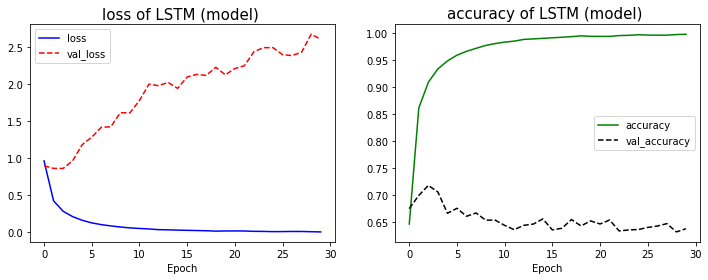

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of LSTM (model) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of LSTM (model) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

# LSTM model2


In [ ]:
n_fold=5
seed=43

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf= StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [ ]:
accuracy=[]
for i,(train, test) in enumerate(skf.split(x_train,y_train),1):
  model2= Sequential()
  model2.add(Embedding(50000, 30))
  model2.add(LSTM(30, activation='tanh'))
  model2.add(Dense(7, activation='softmax'))


  # 모델 컴파일
  model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
  model2.fit(x_train[train], to_categorical(y_train[train]), epochs=20, batch_size=batch_size, validation_data=(x_val[test], to_categorical(y_val[tes])))
  k_accuracy= '%.4f' % (model2.evaluate(x_val[test], y_val[test]))
  accuracy.append(k_accuracy)


print('\n %.f fold accuracy:' % n_fold, accuracy)

ValueError: ignored

In [ ]:
history=model2.fit(x_train, y_train, epochs=20, batch_size=batch_size, validation_split=0.2)

Epoch 1/20
256/256 [==============================] - 8s 32ms/step - loss: 0.0063 - accuracy: 0.9984 - val_loss: 1.5058 - val_accuracy: 0.7470
Epoch 2/20
256/256 [==============================] - 8s 31ms/step - loss: 0.0125 - accuracy: 0.9964 - val_loss: 1.5164 - val_accuracy: 0.7559
Epoch 3/20
256/256 [==============================] - 8s 31ms/step - loss: 0.0089 - accuracy: 0.9973 - val_loss: 1.4035 - val_accuracy: 0.7473
Epoch 4/20
256/256 [==============================] - 8s 31ms/step - loss: 0.0082 - accuracy: 0.9977 - val_loss: 1.6435 - val_accuracy: 0.7533
Epoch 5/20
256/256 [==============================] - 8s 31ms/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 1.7256 - val_accuracy: 0.7452
Epoch 6/20
256/256 [==============================] - 8s 32ms/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 1.6616 - val_accuracy: 0.7441
Epoch 7/20
256/256 [==============================] - 8s 32ms/step - loss: 0.0025 - accuracy: 0.9991 - val_loss: 1.7776 - val_accuracy: 0.7475

<function matplotlib.pyplot.show>

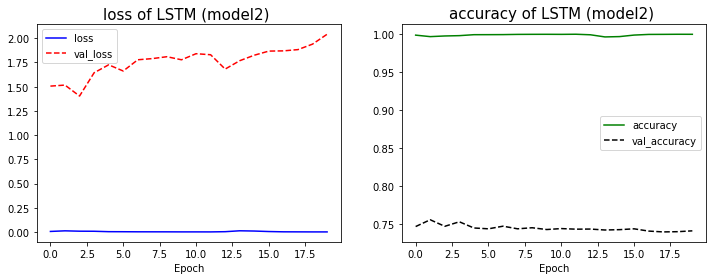

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of LSTM (model2) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of LSTM (model2) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

In [ ]:
test

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간
...,...,...
9126,54780,인천 오후 3시35분 대설주의보…눈 3.1cm 쌓여
9127,54781,노래방에서 지인 성추행 외교부 사무관 불구속 입건종합
9128,54782,40년 전 부마항쟁 부산 시위 사진 2점 최초 공개
9129,54783,게시판 아리랑TV 아프리카개발은행 총회 개회식 생중계


In [ ]:
print('\n test accuracy : %.4f' % (model2.evaluate(x_val, y_val)[1]))

429/429 [==============================] - 1s 3ms/step - loss: 1.8792 - accuracy: 0.7529

 test accuracy : 0.7529


In [ ]:
y_test= np.zeros((y_val.shape[0],7))

y_test += model2.predict(test['y_val'])
y_test


UnimplementedError: ignored

In [ ]:
topic=[]
for i in range(len(y_val)):
  topic.append(np.argmax(y_val[i]))

In [ ]:
submission2 = pd.read_csv("/content/drive/MyDrive/open/sample_submission.csv")

In [ ]:
submission2.head()

,index,topic_idx
0,45654,0
1,45655,0
2,45656,0
3,45657,0
4,45658,0


In [ ]:
submission2['topic_idx']=topic
submission2.head()

ValueError: ignored

In [ ]:
submission.to_csv('/content/drive/MyDrive/submission.csv', index=False)

교차검증

In [ ]:
model2 = Sequential([Embedding(max_words, embedding_dim, input_length =max_len),
        tf.keras.layers.LSTM(units = 64, return_sequences = True),
        tf.keras.layers.LSTM(units = 64, return_sequences = True),
        tf.keras.layers.LSTM(units = 64),
        Dense(7, activation='softmax')    # 결과값이 0~4 이므로 Dense(5)
    ])


In [ ]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical

n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)


for i, (i_trn, i_val) in enumerate(cv.split(x_train, y_train), 1):
    print(f'training model for CV #{i}')

    model2.fit(x_train[i_trn], 
            to_categorical(y_train[i_trn]),
            validation_data=(x_train[i_val], to_categorical(y_train[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])

ValueError: ignored

#  BERT

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 4.1MB/s 
     |████████████████████████████████| 901kB 17.6MB/s 
     |████████████████████████████████| 3.3MB 22.4MB/s 


In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 3.9MB/s 


In [ ]:
import tensorflow as tf
from transformers import BertModel, TFBertModel, BertTokenizer
from tqdm import tqdm

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 44 # EDA에서 추출된 Max Length
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)


In [ ]:
PATH= '/content/drive/MyDrive/open/'
train_data = pd.read_csv(PATH + "train_data.csv")
test_data = pd.read_csv(PATH + "test_data.csv")
submission = pd.read_csv(PATH + "sample_submission.csv")

In [ ]:
def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(train_data["title"], train_data["topic_idx"]), total=len(train_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_movie_input_ids = np.array(input_ids, dtype=int)
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_type_ids = np.array(token_type_ids, dtype=int)
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_movie_input_ids), len(train_data_labels)))

  0%|          | 0/45654 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 45654/45654 [00:14<00:00, 3173.25it/s]


# sents: 45654, # labels: 45654


In [ ]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=7)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
import os

In [ ]:
model_name = "tf2_bert_naver_movie"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_movie_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch

print(history.history)

NameError: ignored

In [ ]:
아앙

In [ ]:
results = cls_model.predict(test_movie_inputs, batch_size=1024)
#results=tf.argmax(results, axis=1)

NameError: ignored

In [ ]:
topic = []
for i in range(len(results)):
    topic.append(np.argmax(results[i]))

In [ ]:
submission['topic_idx']=topic

In [ ]:
submission.to_csv('bert_baseline.csv', index=False)